In [83]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.utils import shuffle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [84]:
BALANCED_DATA_PATH = "./data/earthquake_alert_balanced_dataset.csv"
UNBALANCED_DATA_PATH = "./data/earthquake_data.csv"

In [85]:
balanced_data = pd.read_csv(BALANCED_DATA_PATH)
unbalanced_data = pd.read_csv(UNBALANCED_DATA_PATH)

In [86]:
unbalanced_data.head()

,title,magnitude,date_time,cdi,mmi,alert,tsunami,sig,net,nst,dmin,gap,magType,depth,latitude,longitude,location,continent,country
0,"M 7.0 - 18 km SW of Malango, Solomon Islands",7.0,22-11-2022 02:03,8,7,green,1,768,us,117,0.509,17.0,mww,14.000,-9.7963,159.596,"Malango, Solomon Islands",Oceania,Solomon Islands
1,"M 6.9 - 204 km SW of Bengkulu, Indonesia",6.9,18-11-2022 13:37,4,4,green,0,735,us,99,2.229,34.0,mww,25.000,-4.9559,100.738,"Bengkulu, Indonesia",NaN,NaN
2,M 7.0 -,7.0,12-11-2022 07:09,3,3,green,1,755,us,147,3.125,18.0,mww,579.000,-20.0508,-178.346,NaN,Oceania,Fiji
3,"M 7.3 - 205 km ESE of Neiafu, Tonga",7.3,11-11-2022 10:48,5,5,green,1,833,us,149,1.865,21.0,mww,37.000,-19.2918,-172.129,"Neiafu, Tonga",NaN,NaN
4,M 6.6 -,6.6,09-11-2022 10:14,0,2,green,1,670,us,131,4.998,27.0,mww,624.464,-25.5948,178.278,NaN,NaN,NaN


In [87]:
balanced_data.head()

,magnitude,depth,cdi,mmi,sig,alert
0,7.0,14.0,8.0,7.0,0.0,green
1,6.9,25.0,4.0,4.0,-33.0,green
2,7.0,579.0,3.0,3.0,-13.0,green
3,7.3,37.0,5.0,5.0,65.0,green
4,6.6,624.0,0.0,2.0,-98.0,green


In [88]:
balanced_counts = balanced_data["alert"].value_counts(normalize=True) * 100
unbalanced_counts = unbalanced_data["alert"].value_counts(normalize=True) * 100

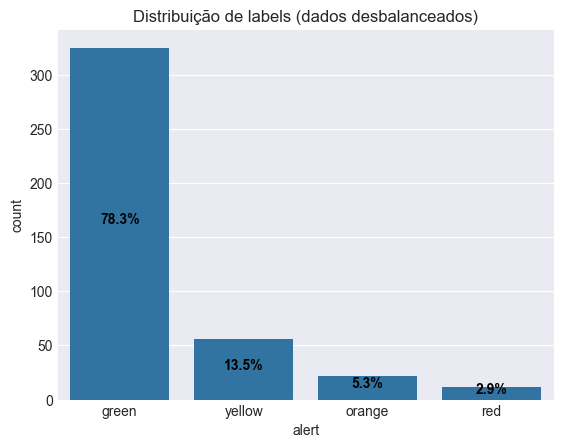

In [89]:
sns.countplot(x="alert", data=unbalanced_data)

for i, v in enumerate(unbalanced_counts):
    plt.text(i, unbalanced_data["alert"].value_counts().iloc[i] / 2, f"{v:.1f}%", color='black', ha='center', fontweight='bold')

plt.title("Distribuição de labels (dados desbalanceados)")
plt.show()

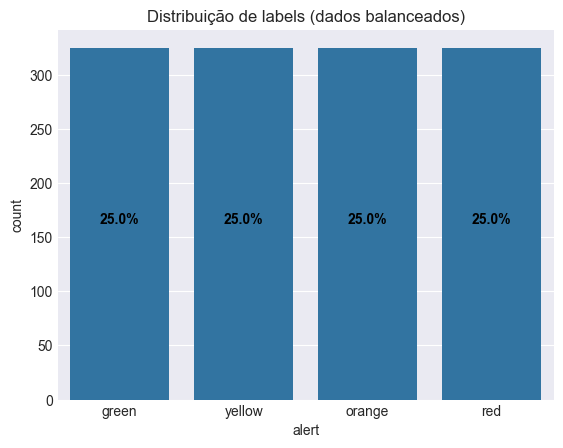

In [90]:
sns.countplot(x="alert", data=balanced_data)

for i, v in enumerate(balanced_counts):
    plt.text(i, balanced_data["alert"].value_counts().iloc[i] / 2, f"{v:.1f}%", color='black', ha='center', fontweight='bold')

plt.title("Distribuição de labels (dados balanceados)")
plt.show()

# Explicação da Base

In [91]:
df = balanced_data.copy()

In [92]:
df.describe()

,magnitude,depth,cdi,mmi,sig
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,7.061008,50.321538,6.976154,6.939231,-9.749231
std,0.423738,104.348286,2.244875,1.354774,62.245214
min,6.500000,2.000000,0.000000,1.000000,-128.000000
25%,6.700000,12.000000,6.000000,6.000000,-54.000000
50%,7.000000,19.000000,8.000000,7.000000,-7.000000
75%,7.300000,38.000000,8.000000,8.000000,31.000000
max,8.600000,670.000000,9.000000,9.000000,127.000000


O conjunto de dados contém 1300 amostras e 6 colunas, representando registros de eventos sísmicos com diferentes intensidades e alertas associados.

Objetivo: prever o nível de alerta (alert) com base nas características físicas do terremoto.

| Coluna      | Tipo                | Descrição                                                                                 |
| ----------- | ------------------- | ----------------------------------------------------------------------------------------- |
| `magnitude` | Numérica (float)    | Medida da energia liberada pelo terremoto na escala Richter.                              |
| `depth`     | Numérica (float)    | Profundidade do epicentro em quilômetros.                                                 |
| `cdi`       | Numérica (float)    | *Community Determined Intensity* – intensidade sentida pela população (escala de 1 a 10). |
| `mmi`       | Numérica (float)    | *Modified Mercalli Intensity* – intensidade dos danos observados (escala de 1 a 12).      |
| `sig`       | Numérica (float)    | Significância do evento (pontuação calculada pelo USGS).                                  |
| `alert`     | Categórica (string) | Variável alvo: nível de alerta — **green**, **yellow**, **orange**, ou **red**.           |


In [93]:
numeric_df = df.select_dtypes(include=["float64", "int64"])
corr = numeric_df.corr()

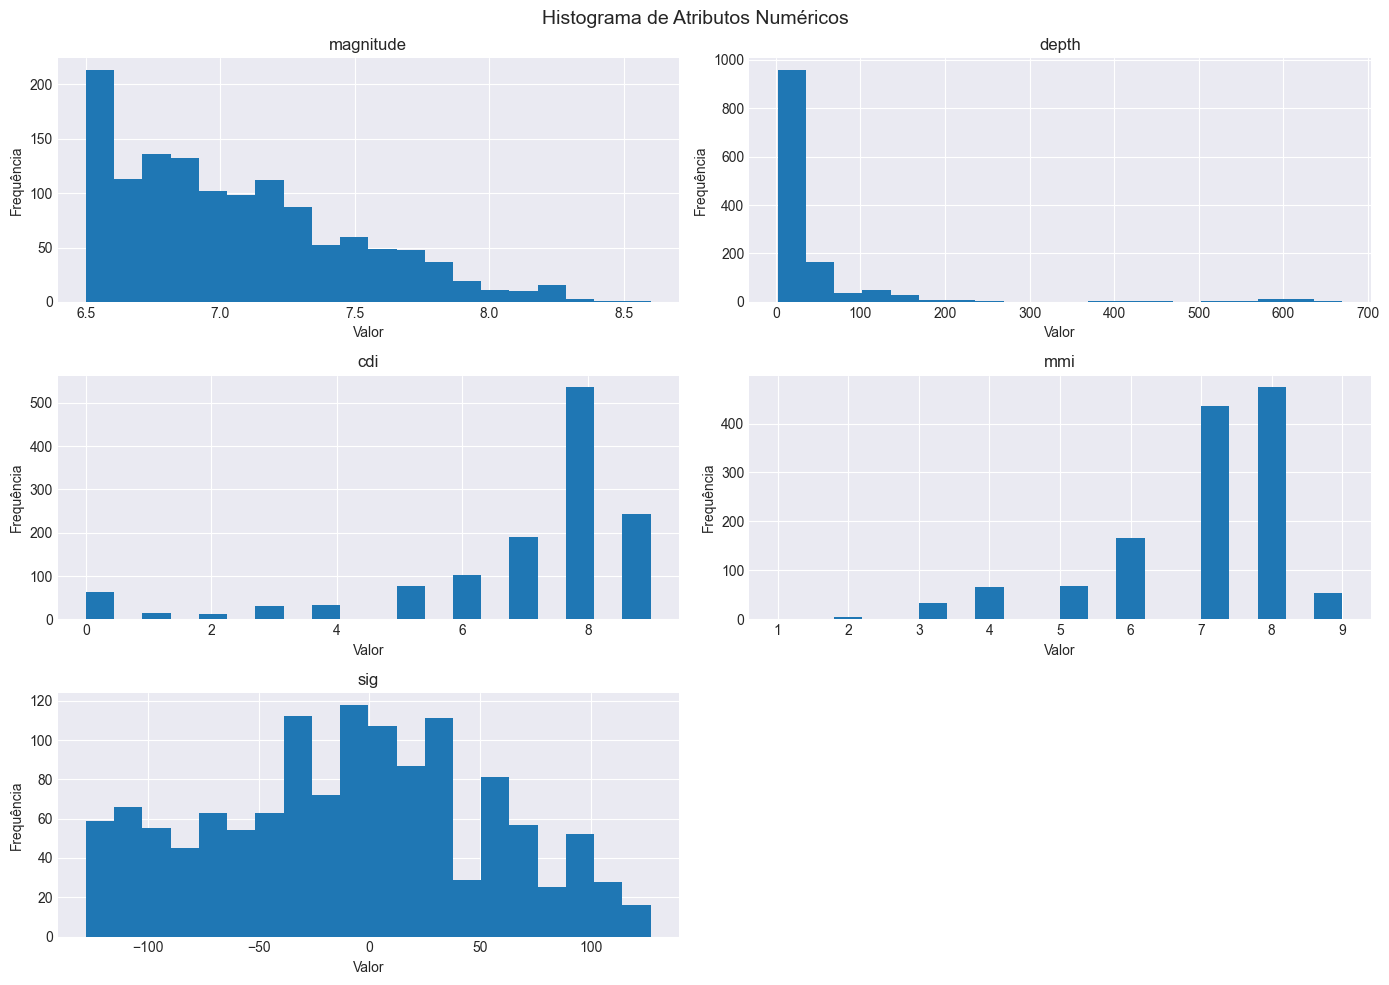

In [94]:
numeric_df.hist(figsize=(14, 10), bins=20)
plt.suptitle("Histograma de Atributos Numéricos", fontsize=14)
for ax in plt.gcf().get_axes():
    ax.set_xlabel('Valor')
    ax.set_ylabel('Frequência')

plt.tight_layout()
plt.show()

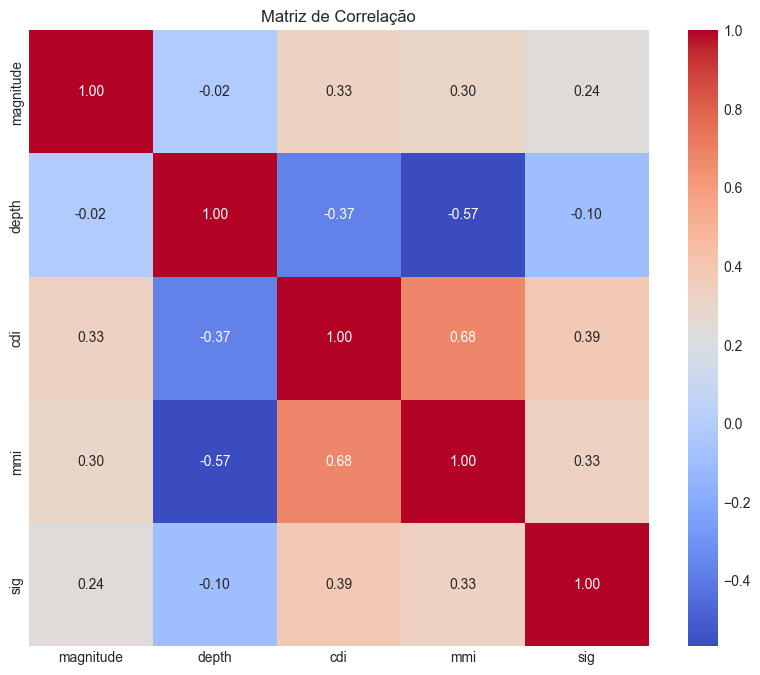

In [95]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

# Pré-Processamento
One-hot Encoding da coluna de labels e padronização com z-score das outras colunas. Foi usado esse método de normalização dos dados numéricos pois eles servirão de entrada para o Multi-Layer Perceptron (MLP).

In [96]:
encoded = pd.get_dummies(df["alert"], prefix="alert", dtype=int)
df = df.drop(columns=["alert"])
df = pd.concat([df, encoded], axis=1)

In [97]:
df["z_magnitude"] = df["magnitude"].apply(lambda x: (x - df["magnitude"].mean()) / df["magnitude"].std())
df["z_depth"] = df["depth"].apply(lambda x: (x - df["depth"].mean()) / df["depth"].std())
df["z_cdi"] = df["cdi"].apply(lambda x: (x - df["cdi"].mean()) / df["cdi"].std())
df["z_mmi"] = df["mmi"].apply(lambda x: (x - df["mmi"].mean()) / df["mmi"].std())
df["z_sig"] = df["sig"].apply(lambda x: (x - df["sig"].mean()) / df["sig"].std())

Embaralhando as amostras para evitar overfitting por enviesamento.

In [98]:
X, y = df[["z_magnitude", "z_depth", "z_cdi", "z_mmi", "z_sig"]], df[["alert_green", "alert_orange", "alert_red", "alert_yellow"]]
X, y = shuffle(X, y, random_state=42)

In [99]:
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# MLP

Divisão em treinamento, teste e validação (70/15/15) usando random_state=42.

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [101]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [102]:
clf = MLPClassifier(hidden_layer_sizes=(16,), max_iter=1000, random_state=42, learning_rate_init=0.01, batch_size=100, solver="adam", warm_start=True)

In [103]:
train_accuracy = []
test_accuracy = []

In [104]:
for i in range(1000):  # número de épocas
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_test)
    train_accuracy.append(accuracy_score(y_train, y_train_pred))
    test_accuracy.append(accuracy_score(y_test, y_val_pred))

In [105]:
train_accuracy = np.array(train_accuracy)
test_accuracy = np.array(test_accuracy)

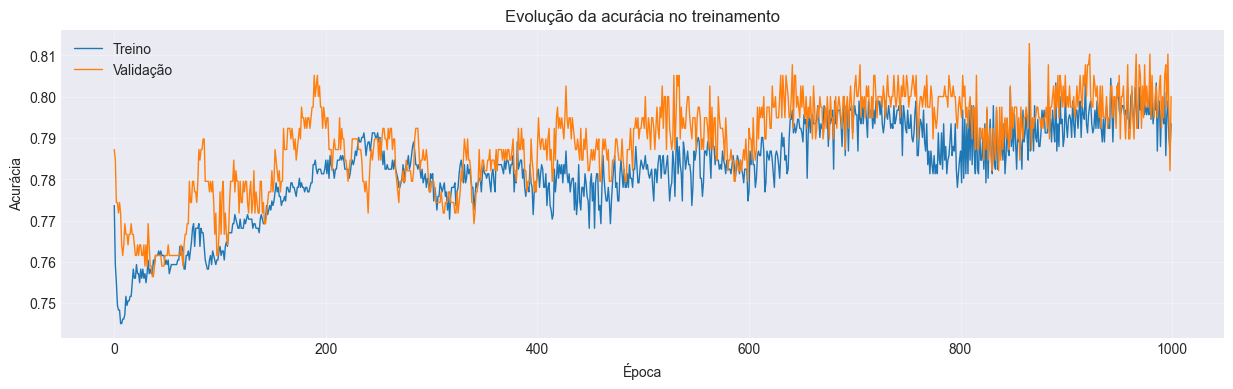

In [106]:
plt.figure(figsize=(15, 4))
plt.plot(train_accuracy, label='Treino', linewidth=1)
plt.plot(test_accuracy, label='Validação', linewidth=1)
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.title("Evolução da acurácia no treinamento")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

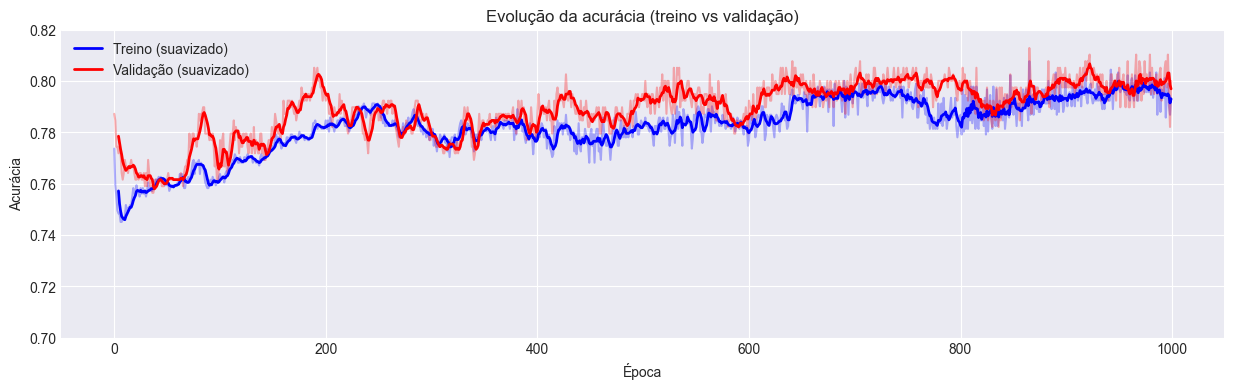

In [107]:
plt.style.use('seaborn-v0_8-darkgrid')

train_smooth = pd.Series(train_accuracy).rolling(5).mean()
test_smooth = pd.Series(test_accuracy).rolling(5).mean()

plt.figure(figsize=(15, 4))

plt.plot(train_accuracy, 'b-', alpha=0.3)
plt.plot(test_accuracy, 'r-', alpha=0.3)

plt.plot(train_smooth, 'b', linewidth=2, label='Treino (suavizado)')
plt.plot(test_smooth, 'r', linewidth=2, label='Validação (suavizado)')

plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.title("Evolução da acurácia (treino vs validação)")
plt.legend()
plt.ylim(0.7, 0.82)
plt.show()

# Análise Detalhada dos Resultados

In [108]:
# Métricas finais

y_test_labels = y_test.idxmax(axis=1).str.replace('alert_', '')
y_pred_labels = pd.DataFrame(y_val_pred, columns=y_test.columns).idxmax(axis=1).str.replace('alert_', '')

print("=" * 70)
print("MÉTRICAS DE PERFORMANCE DO MODELO")
print("=" * 70)
print(f"\nAcurácia no conjunto de TREINO: {train_accuracy[-1]:.4f} ({train_accuracy[-1]*100:.2f}%)")
print(f"Acurácia no conjunto de TESTE: {test_accuracy[-1]:.4f} ({test_accuracy[-1]*100:.2f}%)")
print(f"\nDiferença (overfitting): {(train_accuracy[-1] - test_accuracy[-1])*100:.2f}%")
print("\n" + "=" * 70)

MÉTRICAS DE PERFORMANCE DO MODELO

Acurácia no conjunto de TREINO: 0.7934 (79.34%)
Acurácia no conjunto de TESTE: 0.8000 (80.00%)

Diferença (overfitting): -0.66%



In [109]:
# Relatório de classificação detalhado
print("\nRELATÓRIO DE CLASSIFICAÇÃO")
print("=" * 70)
print(classification_report(y_test_labels, y_pred_labels, target_names=['green', 'orange', 'red', 'yellow']))


RELATÓRIO DE CLASSIFICAÇÃO
              precision    recall  f1-score   support

       green       0.76      0.84      0.79        97
      orange       0.94      0.74      0.83        98
         red       0.86      0.93      0.89        97
      yellow       0.86      0.88      0.87        98

    accuracy                           0.85       390
   macro avg       0.85      0.85      0.85       390
weighted avg       0.85      0.85      0.85       390



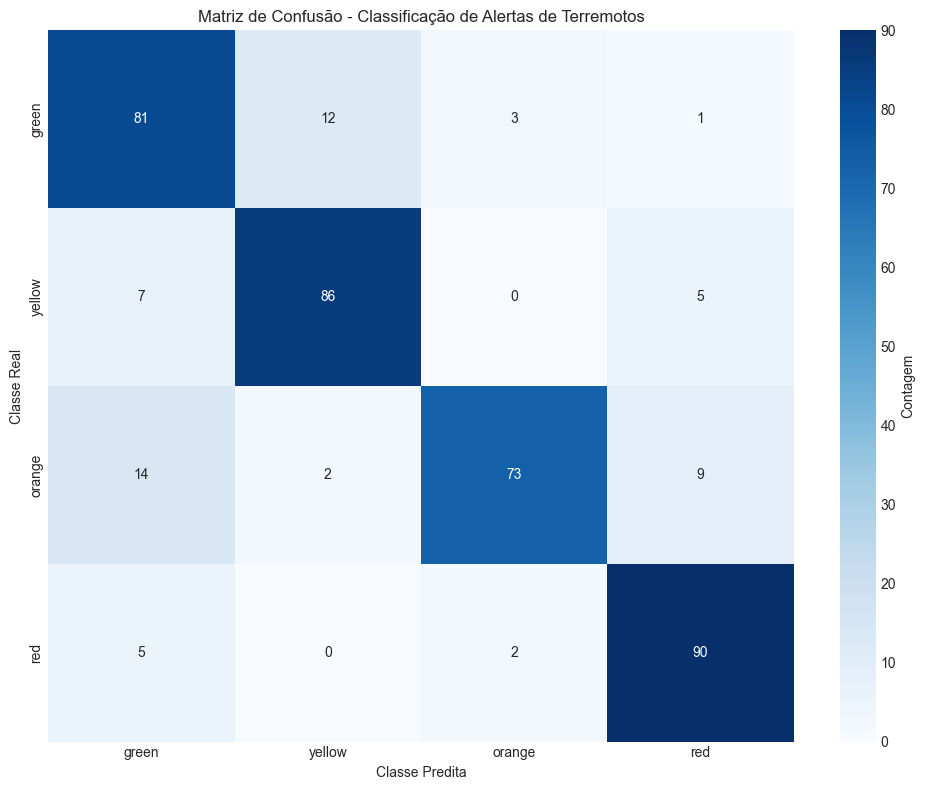


TAXA DE ACERTO POR CLASSE:
GREEN   :  81/ 97 (83.51%)
YELLOW  :  86/ 98 (87.76%)
ORANGE  :  73/ 98 (74.49%)
RED     :  90/ 97 (92.78%)


In [110]:
# Matriz de confusão
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=['green', 'yellow', 'orange', 'red'])

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['green', 'yellow', 'orange', 'red'],
            yticklabels=['green', 'yellow', 'orange', 'red'],
            cbar_kws={'label': 'Contagem'})
plt.title('Matriz de Confusão - Classificação de Alertas de Terremotos')
plt.ylabel('Classe Real')
plt.xlabel('Classe Predita')
plt.tight_layout()
plt.show()

# Calcular taxa de acerto por classe
print("\nTAXA DE ACERTO POR CLASSE:")
print("=" * 70)
for i, label in enumerate(['green', 'yellow', 'orange', 'red']):
    correct = cm[i, i]
    total = cm[i].sum()
    accuracy = correct / total * 100
    print(f"{label.upper():8s}: {correct:3d}/{total:3d} ({accuracy:.2f}%)")

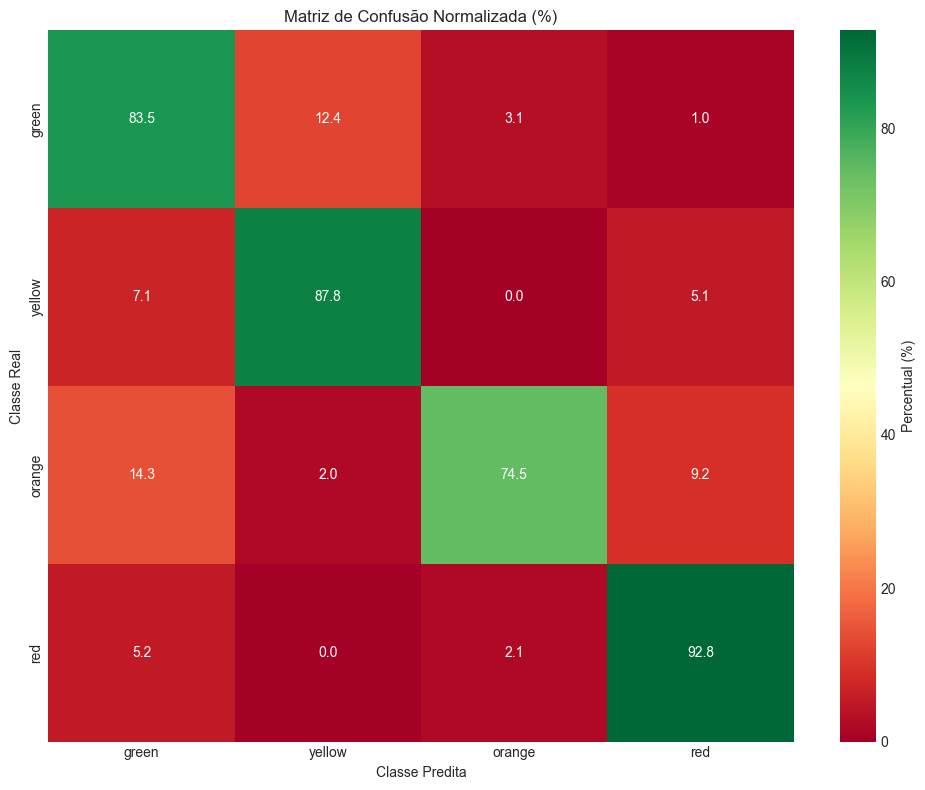

In [111]:
# Matriz de confusão normalizada (percentuais)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='RdYlGn', 
            xticklabels=['green', 'yellow', 'orange', 'red'],
            yticklabels=['green', 'yellow', 'orange', 'red'],
            cbar_kws={'label': 'Percentual (%)'})
plt.title('Matriz de Confusão Normalizada (%)')
plt.ylabel('Classe Real')
plt.xlabel('Classe Predita')
plt.tight_layout()
plt.show()

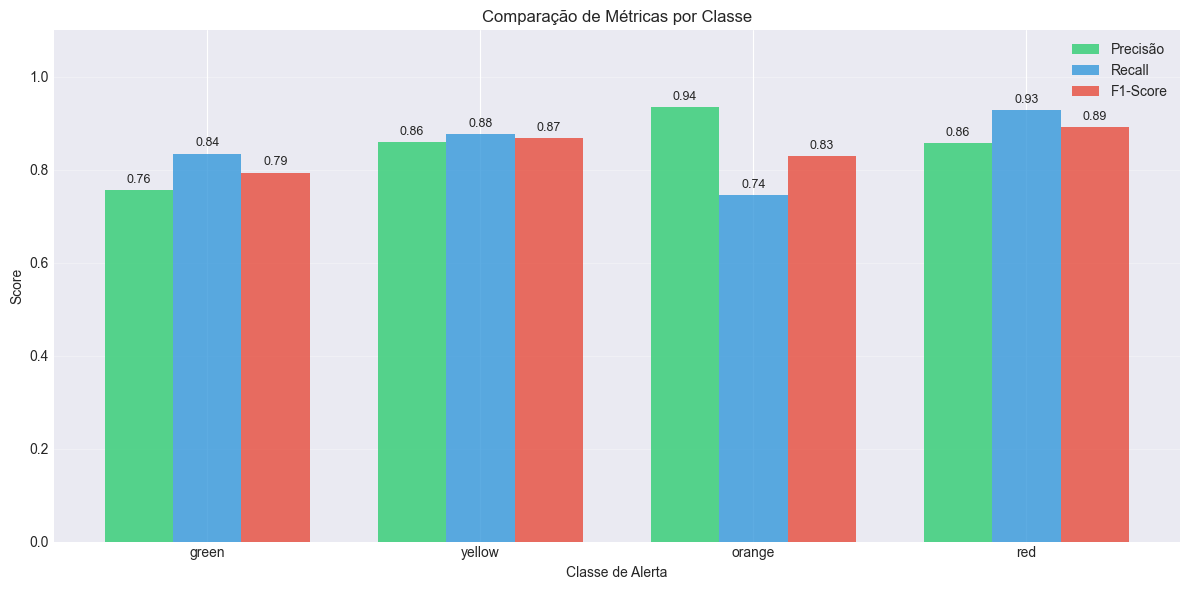

In [112]:
# Comparação de métricas por classe
labels = ['green', 'yellow', 'orange', 'red']
precision = precision_score(y_test_labels, y_pred_labels, labels=labels, average=None, zero_division=0)
recall = recall_score(y_test_labels, y_pred_labels, labels=labels, average=None, zero_division=0)
f1 = f1_score(y_test_labels, y_pred_labels, labels=labels, average=None, zero_division=0)

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width, precision, width, label='Precisão', color='#2ecc71', alpha=0.8)
bars2 = ax.bar(x, recall, width, label='Recall', color='#3498db', alpha=0.8)
bars3 = ax.bar(x + width, f1, width, label='F1-Score', color='#e74c3c', alpha=0.8)

ax.set_xlabel('Classe de Alerta')
ax.set_ylabel('Score')
ax.set_title('Comparação de Métricas por Classe')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3, axis='y')

# Adicionar valores nas barras
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [113]:
# Análise de erros - onde o modelo mais confunde?
error_pairs = []
for i in range(len(labels)):
    for j in range(len(labels)):
        if i != j and cm[i, j] > 0:
            error_pairs.append({
                'Real': labels[i],
                'Predito': labels[j],
                'Contagem': cm[i, j],
                'Percentual': cm_normalized[i, j]
            })

error_df = pd.DataFrame(error_pairs).sort_values('Contagem', ascending=False)

print("\nPRINCIPAIS ERROS DO MODELO:")
print("=" * 70)
print(f"{'Classe Real':<15} {'Predito como':<15} {'Erros':<10} {'% da classe':<15}")
print("-" * 70)
for _, row in error_df.head(10).iterrows():
    print(f"{row['Real']:<15} {row['Predito']:<15} {row['Contagem']:<10.0f} {row['Percentual']:<15.2f}%")


PRINCIPAIS ERROS DO MODELO:
Classe Real     Predito como    Erros      % da classe    
----------------------------------------------------------------------
orange          green           14         14.29          %
green           yellow          12         12.37          %
orange          red             9          9.18           %
yellow          green           7          7.14           %
yellow          red             5          5.10           %
red             green           5          5.15           %
green           orange          3          3.09           %
orange          yellow          2          2.04           %
red             orange          2          2.06           %
green           red             1          1.03           %


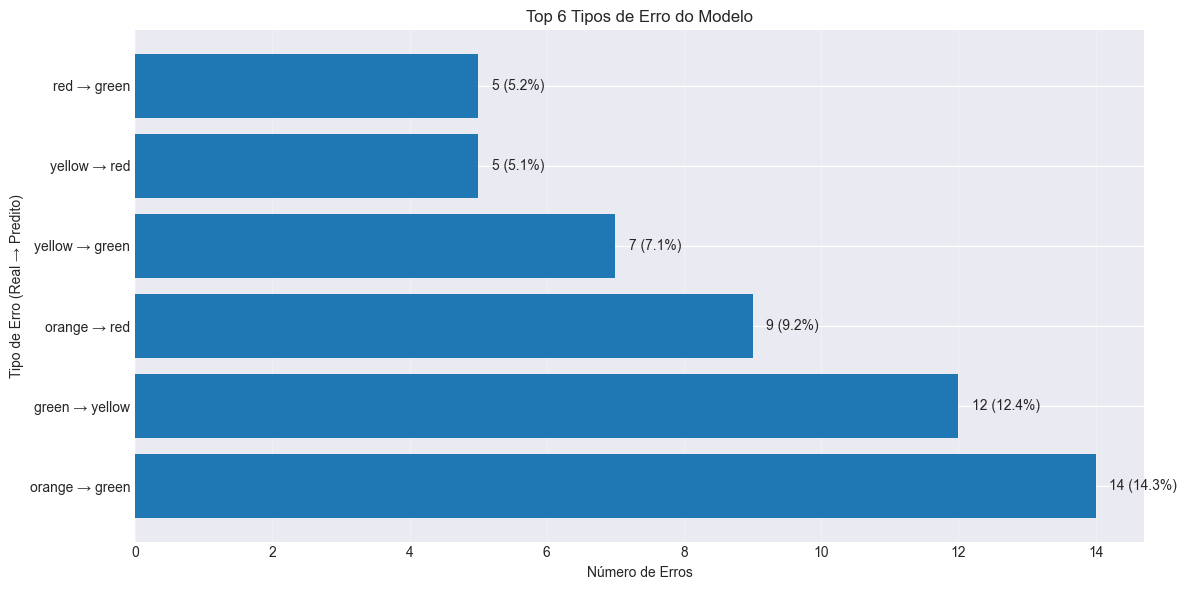

In [ ]:
# Visualização dos erros como gráfico de barras
if len(error_df) > 0:
    top_errors = error_df.head(6)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    error_labels = [f"{row['Real']} → {row['Predito']}" for _, row in top_errors.iterrows()]
    
    bars = ax.barh(error_labels, top_errors['Contagem'])
    
    ax.set_xlabel('Número de Erros')
    ax.set_ylabel('Tipo de Erro (Real → Predito)')
    ax.set_title('Top 6 Tipos de Erro do Modelo')
    ax.grid(True, alpha=0.3, axis='x')
    
    for i, (bar, val) in enumerate(zip(bars, top_errors['Contagem'])):
        ax.text(val + 0.2, bar.get_y() + bar.get_height()/2, 
                f'{int(val)} ({top_errors.iloc[i]["Percentual"]:.1f}%)',
                va='center', fontsize=10)

    plt.tight_layout()
    plt.show()
else:
    print("Modelo não cometeu erros!")

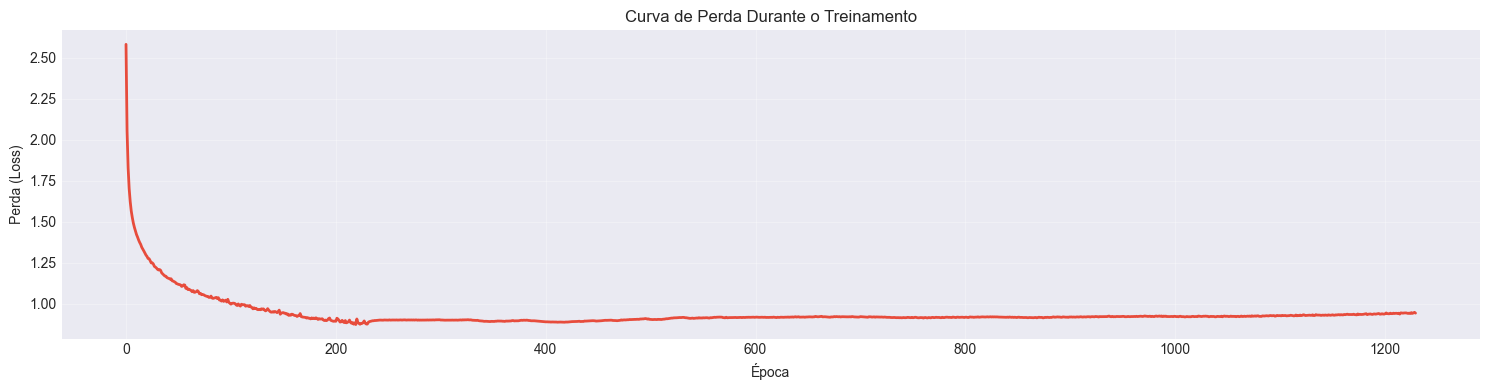


Perda final: 0.942332
Perda inicial: 2.583268
Redução da perda: 63.52%


In [115]:
# Evolução da perda ao longo do treinamento
plt.figure(figsize=(15, 4))
plt.plot(clf.loss_curve_, color='#e74c3c', linewidth=2)
plt.xlabel('Época')
plt.ylabel('Perda (Loss)')
plt.title('Curva de Perda Durante o Treinamento')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nPerda final: {clf.loss_curve_[-1]:.6f}")
print(f"Perda inicial: {clf.loss_curve_[0]:.6f}")
print(f"Redução da perda: {((clf.loss_curve_[0] - clf.loss_curve_[-1]) / clf.loss_curve_[0] * 100):.2f}%")

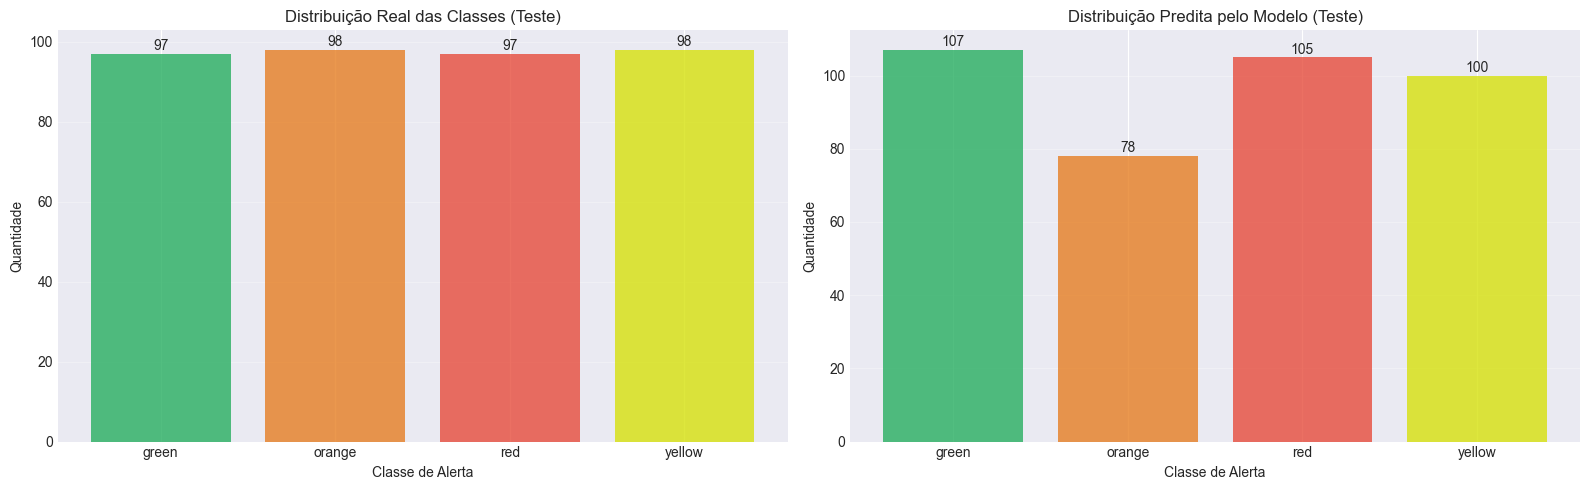

In [121]:
# Análise de distribuição das predições vs reais
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Distribuição real
real_counts = pd.Series(y_test_labels).value_counts().sort_index()
axes[0].bar(real_counts.index, real_counts.values, color=['#27ae60', '#e67e22', '#e74c3c', '#d6e10c'], alpha=0.8)
axes[0].set_title('Distribuição Real das Classes (Teste)')
axes[0].set_xlabel('Classe de Alerta')
axes[0].set_ylabel('Quantidade')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(real_counts.values):
    axes[0].text(i, v + 1, str(v), ha='center')

# Distribuição predita
pred_counts = pd.Series(y_pred_labels).value_counts().sort_index()
axes[1].bar(pred_counts.index, pred_counts.values, color=['#27ae60', '#e67e22', '#e74c3c', "#d6e10c"], alpha=0.8)
axes[1].set_title('Distribuição Predita pelo Modelo (Teste)')
axes[1].set_xlabel('Classe de Alerta')
axes[1].set_ylabel('Quantidade')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(pred_counts.values):
    axes[1].text(i, v + 1, str(v), ha='center')

plt.tight_layout()
plt.show()